In [ ]:
#mount drive and list dir

#mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# set path for directory
%cd drive/MyDrive/monreader

In [19]:
#data_dir='C:/Users/M-ODE/Desktop/Apziva/projects/4th Project/data/images/'
training_dir='data/images/training/'
testing_dir='data/images/testing/'

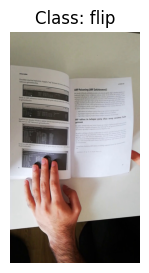

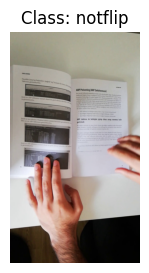

Folder: data/images/training/
Number of classes: 2
Number of samples: 2392
Image Dimensions: Counter({(1920, 1080): 2392})


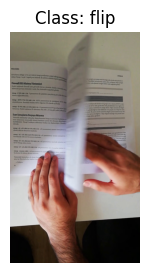

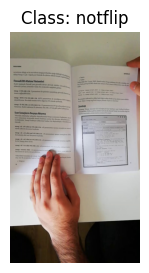

Folder: data/images/testing/
Number of classes: 2
Number of samples: 597
Image Dimensions: Counter({(1920, 1080): 597})


In [ ]:
# Data
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Function to gather statistics and display sample images
def stats_and_display(folder):
    classes = os.listdir(folder)
    num_samples = 0
    dimensions = []

    # Count samples in each class +  image dimensions
    for class_name in classes:
        class_path = os.path.join(folder, class_name)
        samples = os.listdir(class_path)

        num_samples += len(samples)

        for i, sample_name in enumerate(samples):
            sample_path = os.path.join(class_path, sample_name)

            # Load image
            image = cv2.imread(sample_path)
            dimensions.append(image.shape[:2])  # 2D images

            # Display the first image in each class
            if i == 0:
                plt.figure(figsize=(3, 3))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f"Class: {class_name}")
                plt.axis('off')
                plt.show()

    # Display stats
    print(f"Folder: {folder}")
    print(f"Number of classes: {len(classes)}")
    print(f"Number of samples: {num_samples}")
    print(f"Image Dimensions: {Counter(dimensions)}")

# Gather statistics and display samples from the training data
stats_and_display(training_dir)

# Gather statistics and display samples from the testing data
stats_and_display(testing_dir)


In [9]:
#Function for f1 score for keras
from keras import backend as K
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## MobileNet

In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score

# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,

)

# Create an ImageDataGenerator for testing data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data using the generator
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Load and preprocess testing data using the generator
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # To ensure the order of predictions matches the order of images
)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model for binary classification
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(98, activation='relu'))
#model.add(layers.Dropout(0.5))  # Adding dropout for regularization
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy', get_f1])

# Train the model using the generator
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# Save the model
model.save('model-mobilenet.h5')

# Evaluate the model on the test set
y_pred_proba = model.predict(test_generator)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

# Extract true labels from the generator
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f"F1 Score: {f1}")
print(f"Test Accuracy: {accuracy}")


Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Epoch 1/10
75/75 [==============================] - 142s 2s/step - loss: 1.2014 - Accuracy: 0.7634 - get_f1: 0.7620 - val_loss: 0.2068 - val_Accuracy: 0.9397 - val_get_f1: 0.5112
Epoch 2/10
75/75 [==============================] - 138s 2s/step - loss: 0.2043 - Accuracy: 0.9076 - get_f1: 0.9092 - val_loss: 0.1167 - val_Accuracy: 0.9631 - val_get_f1: 0.5246
Epoch 3/10
75/75 [==============================] - 136s 2s/step - loss: 0.1489 - Accuracy: 0.9411 - get_f1: 0.9387 - val_loss: 0.0647 - val_Accuracy: 0.9698 - val_get_f1: 0.5194
Epoch 4/10
75/75 [==============================] - 135s 2s/step - loss: 0.1079 - Accuracy: 0.9490 - get_f1: 0.9493 - val_loss: 0.0565 - val_Accuracy: 0.9816 - val_get_f1: 0.5246
Epoch 5/10
75/75 [==============================] - 133s 2s/step - loss: 0.0845 - Accuracy: 0.9628 - get_f1: 0.9625 - val_loss: 0.0439 - val_Accuracy: 0.9883 - val_get_f1: 0.5263
Epoch 6/10
75/75 [====

C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 28s 1s/step
F1 Score: 0.9918166939443536
Test Accuracy: 0.9916247906197655


In [87]:
#predict_image("data/images/testing/notflip/0001_000000002.jpg")

In [30]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Load the pre-trained MobileNet model with custom metric function
model = load_model('model-mobilenet.h5', custom_objects={'get_f1': get_f1})

# Function to preprocess and predict
def predict_image(img):
    # Convert PIL image to NumPy array
    img = img.resize((150, 150))  # Resize image to the model's expected size
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    # Make a prediction
    # Make a prediction
    prediction = model.predict(img_array)
    probability_not_flip = prediction[0, 0] * 100  # Probability for "Not Flip"
    probability_flip = 100 - probability_not_flip  # Probability for "Flip"
    
    # Convert the prediction to a class label
    class_label = "Not Flip" if probability_not_flip > 50 else "Flip"
    if class_label == "Not Flip":
        final_probability=probability_not_flip
    elif class_label == "Flip":
        final_probability=probability_flip
        
    return class_label, final_probability



# Define sample images
sample_images = [
    "sample/sample1.jpg",
   "sample/sample2.jpg",
    "sample/sample3.jpg",
    "sample/sample4.jpg",
    "sample/sample5.jpg",
    "sample/sample6.jpg",
    "sample/sample7.jpg",
    "sample/sample8.jpg",
]

# Create a Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Class Label"), gr.Textbox(label="Probability")],
    examples=[[sample_image] for sample_image in sample_images],
    live=True,
    title="Flipping Page Detector",
    description="Upload an image to classify whether it is a flip or not ",
)

# Launch the Gradio interface
iface.launch()


Running on local URL:  http://127.0.0.1:7872

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 2s 2s/step


In [31]:
!pip freeze > requirements.txt

Traceback (most recent call last):
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\queueing.py", line 456, in call_prediction
    output = await route_utils.call_process_api(
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1522, in process_api
    result = await self.call_function(
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1144, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "C:\Users\M-ODE\AppData\Local\Programs\Python\Python310\lib\site-packa

1/1 [==============================] - 0s 201ms/step
